Python version should be `3.11`.

Scikit-learn version should be `1.5.2`.

In [1]:
import sklearn
import platform

print(f"Python version is {platform.python_version()}")
print(f"Scikit-learn version is {sklearn.__version__}")

Python version is 3.11.9
Scikit-learn version is 1.5.2


## Import data

In [2]:
import pandas as pd
df1 = pd.read_parquet("validated_data/cleaned1.parquet")
df2 = pd.read_parquet("validated_data/cleaned2.parquet")
df3 = pd.read_parquet("validated_data/cleaned3.parquet")

dfs = [df1, df2, df3]
for i, df in enumerate(dfs):
    dfs[i] = df[df["Faulty"] == False]
    print(f"Building {i+1} has {len(dfs[i])} out of {len(df)} valid rows.")
df1, df2, df3 = dfs

Building 1 has 376821 out of 2097150 valid rows.
Building 2 has 22716 out of 520938 valid rows.
Building 3 has 467517 out of 1942515 valid rows.


## Data preparation

In [3]:
#df2.groupby("Zone_name").count()

Only keep columns with useful information.
- `Slab_temp` and `Dew_temp` values do not vary in building 1
- `building_no` is the same value within dataframes
- `Fan_on_group` and `Cumulative_fan_on_mins` values were calculated using the target variable `Fan_status`
- `Date` and `Time` cannot be easily converted to numeric values
- `Year` values should probably not be used for prediction
- `Damper_open_group` and `Louver_open_group` are categorical labels
- Cumulative metrics probably won't be available when trying to predict future values
- `Louver_status` values are missing in building 3

In [4]:
exclude = ["building_no", "Fan_on_group", "Date", "Time", "Year", "Damper_open_group", "Louver_open_group", "Faulty", "Cumulative_fan_on_mins", "Cumulative_damper_open_mins", "Cumulative_louver_open_mins"]
exclude_df1 = exclude + ["Slab_temp", "Dew_temp", "Slab_temp_diff", "Dew_temp_diff"]
exclude_df3 = exclude + ["Louver_status"]

df1 = df1[df1.columns.difference(exclude_df1)]
df2 = df2[df2.columns.difference(exclude)]
df3 = df3[df3.columns.difference(exclude_df3)]
dfs = [df1, df2, df3]

Use `Datetime` to get day of year and minutes past midnight

In [5]:
for df in dfs:
    df["Day_of_Year"] = df["Datetime"].dt.day_of_year
    df["Minutes_past_midnight"] = ((df["Datetime"] - df["Datetime"].dt.normalize()) / pd.Timedelta(minutes=1))
    #df["DOW"] = df["Datetime"].dt.day_name().astype("category")
    del df["Datetime"]

#import seaborn as sns
#sns.heatmap(df1[df1.columns.difference(["Fan_status", "Zone_name", "DOW"])].corr(), cmap="BrBG", vmin=-1, vmax=1)

Remove rows with `NA` values for columns that do not have many `NA` values.

In [6]:
for df in dfs:
    # limit to columns with less than 5% NA values
    cutoff = len(df) // 20

    sums = df.isna().sum()
    sums = sums[sums != 0]
    #print(cutoff)
    #print(sums)
    sums = sums[sums <= cutoff]
    df.dropna(subset=sums.index, inplace=True)

We need to transform `Zone_name` from categorical to numeric. We'll use scikit-learn preprocessing for encoding.

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import TargetEncoder

def encode(categorical_columns: list[int] | list[int]):
    return make_column_transformer((TargetEncoder(random_state=42), categorical_columns), remainder="passthrough")

#categorical_columns = ["Zone_name"]
#categorical_columns = ["Zone_name", "DOW"]
#df1 = pd.get_dummies(df1, columns=categorical_columns)
#dfs[0] = df1
#df2 = pd.get_dummies(df2, columns=categorical_columns)
#dfs[1] = df2
#df3 = pd.get_dummies(df3, columns=categorical_columns)
#dfs[2] = df3

Dump the processed datasets.

In [8]:
from pathlib import Path

save_folder = Path("output/data")
save_folder.mkdir(parents=True, exist_ok=True)
for i, df in enumerate(dfs):
    df.to_parquet(save_folder / f"building{i+1}.parquet")

## Split datasets into training and testing subsets
We use a 80% training, 10% validation, 10% testing split.

In [9]:
from sklearn.model_selection import train_test_split

train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
val1, test1 = train_test_split(test1, test_size=0.5, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.2, random_state=42)
val2, test2 = train_test_split(test2, test_size=0.5, random_state=42)
train3, test3 = train_test_split(df3, test_size=0.2, random_state=42)
val3, test3 = train_test_split(test3, test_size=0.5, random_state=42)

Use random undersampling to handle unbalanced training sets.

In [10]:
target = "Fan_status"

for train in [train1, train2, train3]:
    counts = train[target].value_counts()
    if counts["On"] > counts["Off"] * 3:
        # data is already in random order, so we can just remove the relevant records after the cutoff
        drop = train[train[target] == "On"].index[counts["Off"] * 3:]
        #train.drop(drop, inplace=True)
    elif counts["Off"] > counts["On"] * 3:
        drop = train[train[target] == "Off"].index[counts["On"] * 3:]
        #train.drop(drop, inplace=True)

In [11]:
features1 = df1.columns.to_list()
features1.remove(target)
y_train1 = train1[target]
y_val1 = val1[target]
y_test1 = test1[target]
x_train1 = train1[features1]
x_val1 = val1[features1]
x_test1 = test1[features1]

features2 = df2.columns.to_list()
features2.remove(target)
y_train2 = train2[target]
y_val2 = val2[target]
y_test2 = test2[target]
x_train2 = train2[features2]
x_val2 = val2[features2]
x_test2 = test2[features2]

features3 = df3.columns.to_list()
features3.remove(target)
y_train3 = train3[target]
y_val3 = val3[target]
y_test3 = test3[target]
x_train3 = train3[features3]
x_val3 = val3[features3]
x_test3 = test3[features3]

## Saving and loading models

In [12]:
from sklearn.base import BaseEstimator
from joblib import dump, load

def save_model(model: BaseEstimator, filename: str):
    models_folder = Path("output/models")
    models_folder.mkdir(parents=True, exist_ok=True)
    filename = filename + ".joblib"
    dump(model, models_folder / filename)

def load_model(filename: str) -> BaseEstimator | None:
    models_folder = Path("output/models")
    filename = filename + ".joblib"
    filename: Path = models_folder / filename
    if filename.is_file():
        #print("File found!")
        return load(filename)
    #print("File does not exist!")

## Evaluating Model Performance

In [13]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix

def calculate_metrics(model: BaseEstimator, X: pd.Series, y: pd.Series, print_report = True):
    y_predict = model.predict(X)
    # SVM predictions take a long time to compute and are unreliable (https://stackoverflow.com/questions/15111408/how-does-sklearn-svm-svcs-function-predict-proba-work-internally)
    #y_proba = model.predict_proba(X)[:,1]

    if print_report:
        print(classification_report(y, y_predict, digits=4))
    
    tn, fp, fn, tp = confusion_matrix(y, y_predict).ravel()

    return {
        "Accuracy": accuracy_score(y, y_predict),
        "f1": f1_score(y, y_predict, pos_label="On"),
        #"ROC AUC": roc_auc_score(y, y_proba),
        #"PR AUC": average_precision_score(y, y_proba, pos_label="On"),
        "Matthews": matthews_corrcoef(y, y_predict),
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
    }

model_metrics = {f"Building {n+1}": {} for n in range(3)}
tuned_metrics = {f"Building {n+1}": {} for n in range(3)}

## Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

tree = DecisionTreeClassifier(random_state=42)
tree = make_pipeline(encode(["Zone_name"]), tree)
model_name = "Decision Tree"

### Building 1

In [15]:
tree.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(tree, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(tree, x_test1, y_test1, print_report=False)
save_model(tree, "decisiontree_building1")

              precision    recall  f1-score   support

         Off     0.9996    0.9998    0.9997     26636
          On     0.9996    0.9989    0.9993     10439

    accuracy                         0.9996     37075
   macro avg     0.9996    0.9994    0.9995     37075
weighted avg     0.9996    0.9996    0.9996     37075



### Building 2

In [16]:
tree.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(tree, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(tree, x_test2, y_test2, print_report=False)
save_model(tree, "decisiontree_building2")

              precision    recall  f1-score   support

         Off     0.9917    0.9913    0.9915      2173
          On     0.8081    0.8163    0.8122        98

    accuracy                         0.9837      2271
   macro avg     0.8999    0.9038    0.9018      2271
weighted avg     0.9838    0.9837    0.9837      2271



### Building 3

In [17]:
tree.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(tree, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(tree, x_test3, y_test3, print_report=False)
save_model(tree, "decisiontree_building3")

              precision    recall  f1-score   support

         Off     0.9993    0.9990    0.9992     45760
          On     0.9549    0.9675    0.9612       985

    accuracy                         0.9984     46745
   macro avg     0.9771    0.9833    0.9802     46745
weighted avg     0.9984    0.9984    0.9984     46745



## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

model_name = "Random Forest"
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest = make_pipeline(encode(["Zone_name"]), forest)

### Building 1

<Axes: >

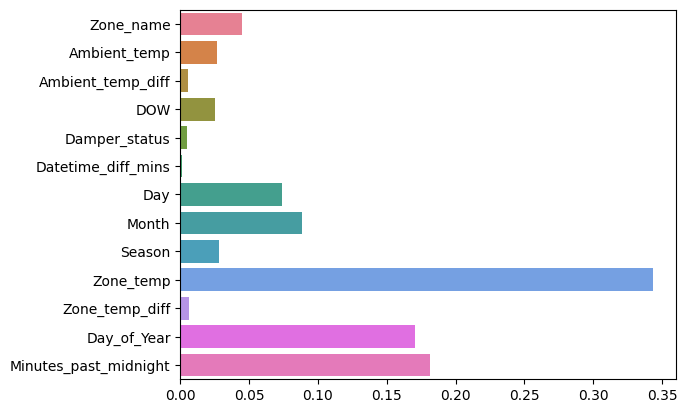

In [19]:
forest.fit(x_train1, y_train1)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [20]:
model_metrics["Building 1"][model_name] = calculate_metrics(forest, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(forest, x_test1, y_test1, print_report=False)
save_model(forest, "randomforest_building1")

              precision    recall  f1-score   support

         Off     0.9994    1.0000    0.9997     26636
          On     0.9999    0.9986    0.9992     10439

    accuracy                         0.9996     37075
   macro avg     0.9997    0.9993    0.9995     37075
weighted avg     0.9996    0.9996    0.9996     37075



### Building 2

<Axes: >

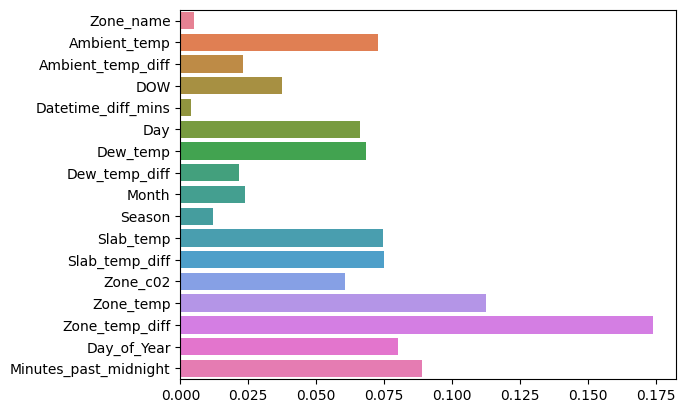

In [21]:
forest.fit(x_train2, y_train2)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [22]:
model_metrics["Building 2"][model_name] = calculate_metrics(forest, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(forest, x_test2, y_test2, print_report=False)
save_model(forest, "randomforest_building2")

              precision    recall  f1-score   support

         Off     0.9922    0.9982    0.9952      2173
          On     0.9529    0.8265    0.8852        98

    accuracy                         0.9908      2271
   macro avg     0.9726    0.9123    0.9402      2271
weighted avg     0.9905    0.9908    0.9904      2271



### Building 3

<Axes: >

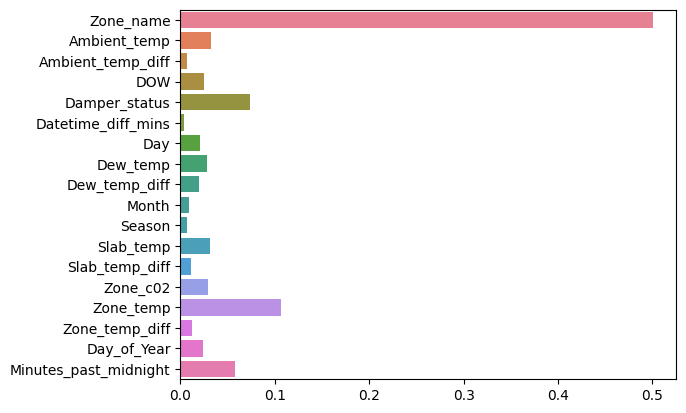

In [23]:
forest.fit(x_train3, y_train3)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [24]:
model_metrics["Building 3"][model_name] = calculate_metrics(forest, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(forest, x_test3, y_test3, print_report=False)
save_model(forest, "randomforest_building3")

              precision    recall  f1-score   support

         Off     0.9988    0.9997    0.9993     45760
          On     0.9852    0.9462    0.9653       985

    accuracy                         0.9986     46745
   macro avg     0.9920    0.9729    0.9823     46745
weighted avg     0.9986    0.9986    0.9986     46745



## Histogram-based Gradient Boosting

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

model_name = "Hist Gradient Boosting"
histgb = HistGradientBoostingClassifier(random_state=42, categorical_features=["Zone_name"])

In [26]:
histgb.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(histgb, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(histgb, x_test1, y_test1, print_report=False)
save_model(histgb, "histgb_building1")

              precision    recall  f1-score   support

         Off     0.9997    0.9998    0.9997     26636
          On     0.9995    0.9991    0.9993     10439

    accuracy                         0.9996     37075
   macro avg     0.9996    0.9995    0.9995     37075
weighted avg     0.9996    0.9996    0.9996     37075



In [27]:
histgb.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(histgb, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(histgb, x_test2, y_test2, print_report=False)
save_model(histgb, "histgb_building2")

              precision    recall  f1-score   support

         Off     0.9922    0.9972    0.9947      2173
          On     0.9310    0.8265    0.8757        98

    accuracy                         0.9899      2271
   macro avg     0.9616    0.9119    0.9352      2271
weighted avg     0.9896    0.9899    0.9896      2271



In [28]:
histgb.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(histgb, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(histgb, x_test3, y_test3, print_report=False)
save_model(histgb, "histgb_building3")

              precision    recall  f1-score   support

         Off     0.9993    0.9992    0.9993     45760
          On     0.9637    0.9695    0.9666       985

    accuracy                         0.9986     46745
   macro avg     0.9815    0.9844    0.9829     46745
weighted avg     0.9986    0.9986    0.9986     46745



## Logistic Regression

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression"
logit = LogisticRegression(random_state=42)
logit = make_pipeline(encode(["Zone_name"]), SimpleImputer(), StandardScaler(), logit)

In [30]:
logit.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(logit, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(logit, x_test1, y_test1, print_report=False)
save_model(logit, "logit_building1")

              precision    recall  f1-score   support

         Off     0.8199    0.8899    0.8535     26636
          On     0.6409    0.5014    0.5626     10439

    accuracy                         0.7805     37075
   macro avg     0.7304    0.6956    0.7080     37075
weighted avg     0.7695    0.7805    0.7716     37075



In [31]:
logit.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(logit, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(logit, x_test2, y_test2, print_report=False)
save_model(logit, "logit_building2")

              precision    recall  f1-score   support

         Off     0.9661    0.9972    0.9814      2173
          On     0.7857    0.2245    0.3492        98

    accuracy                         0.9639      2271
   macro avg     0.8759    0.6109    0.6653      2271
weighted avg     0.9583    0.9639    0.9541      2271



In [32]:
logit.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(logit, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(logit, x_test3, y_test3, print_report=False)
save_model(logit, "logit_building3")

              precision    recall  f1-score   support

         Off     0.9909    0.9999    0.9954     45760
          On     0.9912    0.5726    0.7259       985

    accuracy                         0.9909     46745
   macro avg     0.9910    0.7862    0.8606     46745
weighted avg     0.9909    0.9909    0.9897     46745



## Linear Discriminant Analysis

In [33]:
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_name = "Linear Discriminant Analysis"
lda = LinearDiscriminantAnalysis()
lda = make_pipeline(encode(["Zone_name"]), SimpleImputer(), lda)

In [34]:
lda.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(lda, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(lda, x_test1, y_test1, print_report=False)
save_model(lda, "lda_building1")

              precision    recall  f1-score   support

         Off     0.8594    0.8939    0.8763     26636
          On     0.6984    0.6270    0.6608     10439

    accuracy                         0.8187     37075
   macro avg     0.7789    0.7604    0.7686     37075
weighted avg     0.8141    0.8187    0.8156     37075



In [35]:
lda.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(lda, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(lda, x_test2, y_test2, print_report=False)
save_model(lda, "lda_building2")

              precision    recall  f1-score   support

         Off     0.9682    0.9936    0.9807      2173
          On     0.6585    0.2755    0.3885        98

    accuracy                         0.9626      2271
   macro avg     0.8133    0.6345    0.6846      2271
weighted avg     0.9548    0.9626    0.9551      2271



In [36]:
lda.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(lda, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(lda, x_test3, y_test3, print_report=False)
save_model(lda, "lda_building3")

              precision    recall  f1-score   support

         Off     0.9908    1.0000    0.9954     45760
          On     1.0000    0.5675    0.7241       985

    accuracy                         0.9909     46745
   macro avg     0.9954    0.7838    0.8597     46745
weighted avg     0.9910    0.9909    0.9897     46745



## Linear Support Vector Machine (SVM)

In [37]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC

model_name = "Linear SVM"
svm = LinearSVC(random_state=42)
svm = make_pipeline(encode(["Zone_name"]), SimpleImputer(), MinMaxScaler(), Normalizer(), svm)

In [38]:
svm.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(svm, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(svm, x_test1, y_test1, print_report=False)
save_model(svm, "svm_linear_building1")

              precision    recall  f1-score   support

         Off     0.8715    0.8749    0.8732     26636
          On     0.6775    0.6708    0.6741     10439

    accuracy                         0.8174     37075
   macro avg     0.7745    0.7728    0.7736     37075
weighted avg     0.8169    0.8174    0.8171     37075



In [39]:
svm.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(svm, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(svm, x_test2, y_test2, print_report=False)
save_model(svm, "svm_linear_building2")

              precision    recall  f1-score   support

         Off     0.9568    1.0000    0.9779      2173
          On     0.0000    0.0000    0.0000        98

    accuracy                         0.9568      2271
   macro avg     0.4784    0.5000    0.4890      2271
weighted avg     0.9156    0.9568    0.9357      2271



c:\Users\Alan\Documents\COS40006\COS40005 Computing Technology Project A\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alan\Documents\COS40006\COS40005 Computing Technology Project A\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Alan\Documents\COS40006\COS40005 Computing Technology Project A\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [40]:
svm.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(svm, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(svm, x_test3, y_test3, print_report=False)
save_model(svm, "svm_linear_building3")

              precision    recall  f1-score   support

         Off     0.9908    1.0000    0.9954     45760
          On     1.0000    0.5675    0.7241       985

    accuracy                         0.9909     46745
   macro avg     0.9954    0.7838    0.8597     46745
weighted avg     0.9910    0.9909    0.9897     46745



## SVM with RBF Kernel

SVM takes a long time for large datasets. Even after loading the saved model file, making predictions on the buildings takes around ~~1 hour~~ 6 minutes.

In [41]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

model_name = "RBF SVM"
svm = SVC(random_state=42)
svm = make_pipeline(encode(["Zone_name"]), SimpleImputer(), MinMaxScaler(), Normalizer(), svm)

In [42]:
#from sklearn.preprocessing import MinMaxScaler, Normalizer
#from sklearn.impute import SimpleImputer
#from sklearn.svm import LinearSVC
#from sklearn.kernel_approximation import Nystroem

#model_name = "SVM (RBF)"
#svm = LinearSVC(random_state=42)
#svm = make_pipeline(encode(["Zone_name"]), SimpleImputer(), MinMaxScaler(), Normalizer(), Nystroem(), svm)

In [43]:
# Building 1 SVM training took around 15 minutes (3 hours for the original dataset). Calculating metrics alone takes about 3 minutes.
model_file = "svm_rbf_building1"
if load_model(model_file):
    print("Loading previously saved model")
    svm = load_model(model_file)
    model_metrics["Building 1"][model_name] = calculate_metrics(svm, x_val1, y_val1)
    tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(svm, x_test1, y_test1, print_report=False)
else:
    print("Training model...")
    svm.fit(x_train1, y_train1)
    save_model(svm, model_file)
    model_metrics["Building 1"][model_name] = calculate_metrics(svm, x_val1, y_val1)
    tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(svm, x_test1, y_test1, print_report=False)

Training model...
              precision    recall  f1-score   support

         Off     0.9762    0.9720    0.9741     26636
          On     0.9294    0.9395    0.9344     10439

    accuracy                         0.9629     37075
   macro avg     0.9528    0.9557    0.9542     37075
weighted avg     0.9630    0.9629    0.9629     37075



In [44]:
svm.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(svm, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(svm, x_test2, y_test2, print_report=False)
save_model(svm, "svm_rbf_building2")

              precision    recall  f1-score   support

         Off     0.9606    0.9986    0.9792      2173
          On     0.7500    0.0918    0.1636        98

    accuracy                         0.9595      2271
   macro avg     0.8553    0.5452    0.5714      2271
weighted avg     0.9515    0.9595    0.9440      2271



In [45]:
svm.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(svm, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(svm, x_test3, y_test3, print_report=False)
save_model(svm, model_file)

              precision    recall  f1-score   support

         Off     0.9921    0.9998    0.9959     45760
          On     0.9857    0.6294    0.7683       985

    accuracy                         0.9920     46745
   macro avg     0.9889    0.8146    0.8821     46745
weighted avg     0.9920    0.9920    0.9911     46745



## Model Performance
### Building 1

In [46]:
pd.DataFrame(model_metrics["Building 1"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Hist Gradient Boosting,0.999622,0.999329,0.999067,26631.0,5.0,9.0,10430.0
Decision Tree,0.999595,0.999281,0.999000,26632.0,4.0,11.0,10428.0
Random Forest,0.999568,0.999233,0.998933,26635.0,1.0,15.0,10424.0
RBF SVM,0.962859,0.934400,0.908524,25891.0,745.0,632.0,9807.0
Linear SVM,0.817397,0.674112,0.547293,23303.0,3333.0,3437.0,7002.0
Linear Discriminant Analysis,0.818746,0.660777,0.539059,23810.0,2826.0,3894.0,6545.0
Logistic Regression,0.780499,0.562614,0.424625,23703.0,2933.0,5205.0,5234.0


### Building 2

In [47]:
pd.DataFrame(model_metrics["Building 2"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Random Forest,0.990753,0.885246,0.882875,2169.0,4.0,17.0,81.0
Hist Gradient Boosting,0.989872,0.875676,0.872093,2167.0,6.0,17.0,81.0
Decision Tree,0.983708,0.812183,0.803679,2154.0,19.0,18.0,80.0
Linear Discriminant Analysis,0.962572,0.388489,0.410639,2159.0,14.0,71.0,27.0
Logistic Regression,0.963893,0.349206,0.408292,2167.0,6.0,76.0,22.0
RBF SVM,0.959489,0.163636,0.253532,2170.0,3.0,89.0,9.0
Linear SVM,0.956847,0.000000,0.000000,2173.0,0.0,98.0,0.0


### Building 3

In [48]:
pd.DataFrame(model_metrics["Building 3"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Hist Gradient Boosting,0.998588,0.966599,0.965883,45724.0,36.0,30.0,955.0
Random Forest,0.998567,0.965303,0.964777,45746.0,14.0,53.0,932.0
Decision Tree,0.998353,0.961170,0.960350,45715.0,45.0,32.0,953.0
RBF SVM,0.991999,0.768278,0.784386,45751.0,9.0,365.0,620.0
Logistic Regression,0.990887,0.725869,0.749820,45755.0,5.0,421.0,564.0
Linear Discriminant Analysis,0.990887,0.724093,0.749852,45760.0,0.0,426.0,559.0
Linear SVM,0.990887,0.724093,0.749852,45760.0,0.0,426.0,559.0


## Model Tuning

Creating and evaluating all model variants takes a long time to complete from scratch. Data will be cached so that future runs will not take as long.

In [49]:
from mlmodel import SCORES
scores = list(SCORES)
save_folder = None

### Decision Tree

In [50]:
from mlmodel import GridSearchDecisionTree
model_name = "Decision Tree"
#save_folder = "output/decision_tree/analysis"
save_folder = None

#### Building 1

All parameters have been previously checked.


<Axes: xlabel='nodes'>

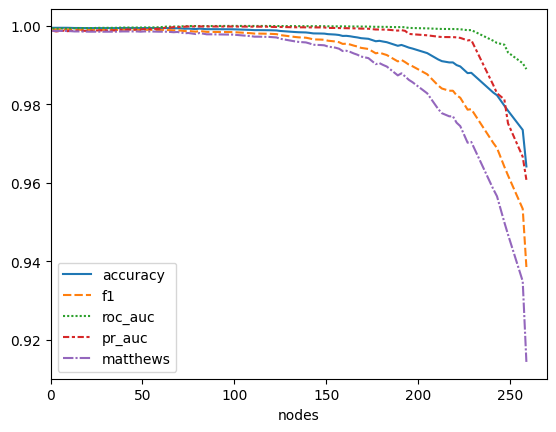

In [51]:
opt1 = GridSearchDecisionTree("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
if save_folder:
    print(opt1.save_results(save_folder))

df = opt1.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
#plt.set_ylim(0.998, 1.0)
display(plt)

In [52]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)
save_model(opt1.model, "decisiontree_building1_tuned")

              precision    recall  f1-score   support

         Off     0.9995    0.9996    0.9995     26732
          On     0.9989    0.9986    0.9988     10343

    accuracy                         0.9993     37075
   macro avg     0.9992    0.9991    0.9992     37075
weighted avg     0.9993    0.9993    0.9993     37075



#### Building 2

100%|██████████| 120/120 [00:04<00:00, 24.43it/s]


<Axes: xlabel='nodes'>

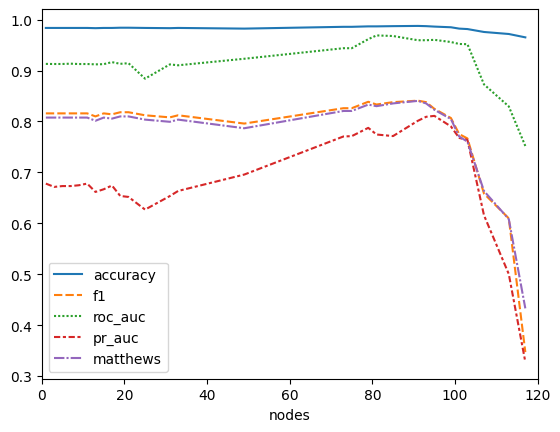

In [53]:
opt2 = GridSearchDecisionTree("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
if save_folder:
    print(opt2.save_results(save_folder))

df = opt2.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
#plt.set_ylim(0.6, 1.0)
display(plt)

In [54]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)
save_model(opt2.model, "decisiontree_building2_tuned")

              precision    recall  f1-score   support

         Off     0.9815    0.9944    0.9879      2135
          On     0.8899    0.7080    0.7886       137

    accuracy                         0.9771      2272
   macro avg     0.9357    0.8512    0.8883      2272
weighted avg     0.9760    0.9771    0.9759      2272



#### Building 3

100%|██████████| 223/223 [01:26<00:00,  2.59it/s]


<Axes: xlabel='nodes'>

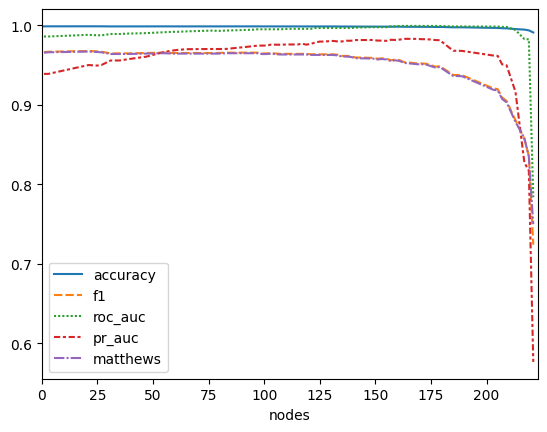

In [55]:
opt3 = GridSearchDecisionTree("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
if save_folder:
    print(opt3.save_results(save_folder))

df = opt3.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
#plt.set_ylim(0.92, 1.0)
display(plt)

In [56]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)
save_model(opt3.model, "decisiontree_building3_tuned")

              precision    recall  f1-score   support

         Off     0.9994    0.9992    0.9993     45812
          On     0.9617    0.9690    0.9653       934

    accuracy                         0.9986     46746
   macro avg     0.9806    0.9841    0.9823     46746
weighted avg     0.9986    0.9986    0.9986     46746



### Random Forest

In [57]:
from mlmodel import GridSearchRandomForest
model_name = "Random Forest"
#save_folder = "output/random_forest/analysis"
save_folder = None

#### Building 1

In [58]:
opt1 = GridSearchRandomForest("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
if save_folder:
    print(opt1.save_results(save_folder))

opt1.model[-1]

100%|██████████| 324/324 [1:25:50<00:00, 15.90s/it]


RandomForestClassifier(max_features=11, n_estimators=150, random_state=42)

<Axes: xlabel='min_samples_split'>

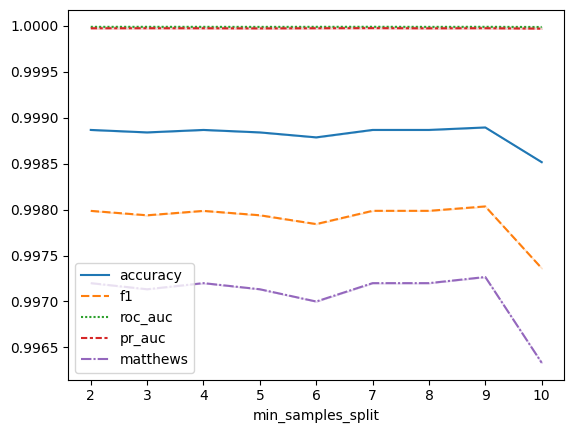

In [59]:
df = opt1.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
#plt.set_xlim(0, df.index.max())
#plt.set_ylim(0.98, 1.0)
display(plt)

In [60]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)
save_model(opt1.model, "randomforest_building1_tuned")

              precision    recall  f1-score   support

         Off     0.9999    0.9999    0.9999     26732
          On     0.9997    0.9997    0.9997     10343

    accuracy                         0.9998     37075
   macro avg     0.9998    0.9998    0.9998     37075
weighted avg     0.9998    0.9998    0.9998     37075



#### Building 2

In [61]:
opt2 = GridSearchRandomForest("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
if save_folder:
    print(opt2.save_results(save_folder))

opt2.model[-1]

100%|██████████| 432/432 [12:34<00:00,  1.75s/it]


RandomForestClassifier(criterion='entropy', max_features=7, min_samples_split=5,
                       n_estimators=50, random_state=42)

<Axes: xlabel='min_samples_split'>

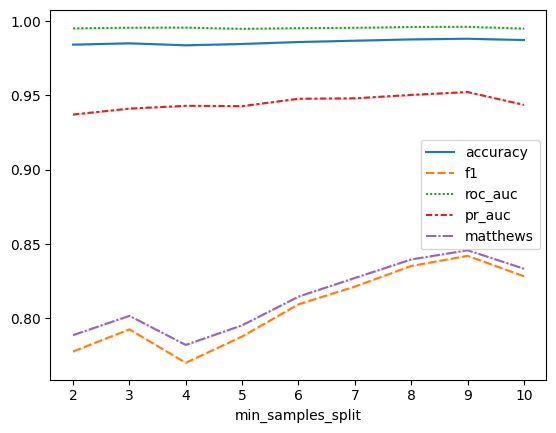

In [62]:
df = opt2.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [63]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)
save_model(opt2.model, "randomforest_building2_tuned")

              precision    recall  f1-score   support

         Off     0.9907    0.9977    0.9942      2135
          On     0.9590    0.8540    0.9035       137

    accuracy                         0.9890      2272
   macro avg     0.9749    0.9258    0.9488      2272
weighted avg     0.9888    0.9890    0.9887      2272



In [64]:
opt3 = GridSearchRandomForest("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
if save_folder:
    print(opt3.save_results(save_folder))

opt3.model[-1]

100%|██████████| 459/459 [3:56:08<00:00, 30.87s/it]  


RandomForestClassifier(criterion='entropy', max_features=17,
                       min_samples_split=3, n_estimators=150, random_state=42)

<Axes: xlabel='min_samples_split'>

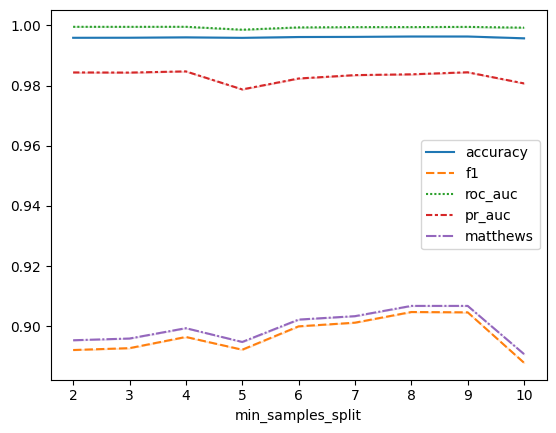

In [65]:
df = opt3.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [66]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)
save_model(opt3.model, "randomforest_building3_tuned")

              precision    recall  f1-score   support

         Off     0.9995    0.9994    0.9995     45812
          On     0.9702    0.9764    0.9733       934

    accuracy                         0.9989     46746
   macro avg     0.9849    0.9879    0.9864     46746
weighted avg     0.9989    0.9989    0.9989     46746



## Tuned Model Performance
### Building 1

In [67]:
pd.DataFrame(tuned_metrics["Building 1"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Random Forest,0.999838,0.999710,0.999598,26729.0,3.0,3.0,10340.0
Random Forest (default),0.999784,0.999613,0.999464,26730.0,2.0,6.0,10337.0
Hist Gradient Boosting (default),0.999595,0.999275,0.998994,26723.0,9.0,6.0,10337.0
Decision Tree (default),0.999514,0.999130,0.998793,26723.0,9.0,9.0,10334.0
Decision Tree,0.999326,0.998791,0.998324,26721.0,11.0,14.0,10329.0
RBF SVM (default),0.963048,0.933976,0.908329,26015.0,717.0,653.0,9690.0
Linear SVM (default),0.819042,0.676534,0.550924,23350.0,3382.0,3327.0,7016.0
Linear Discriminant Analysis (default),0.818827,0.658949,0.537285,23869.0,2863.0,3854.0,6489.0
Logistic Regression (default),0.779501,0.559370,0.419832,23711.0,3021.0,5154.0,5189.0


### Building 2

In [68]:
pd.DataFrame(tuned_metrics["Building 2"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Hist Gradient Boosting (default),0.990757,0.918919,0.915764,2132.0,3.0,18.0,119.0
Random Forest,0.988996,0.903475,0.899358,2130.0,5.0,20.0,117.0
Random Forest (default),0.984155,0.856000,0.852102,2129.0,6.0,30.0,107.0
Decision Tree,0.977113,0.788618,0.782362,2123.0,12.0,40.0,97.0
Decision Tree (default),0.974032,0.777358,0.764084,2110.0,25.0,34.0,103.0
Linear Discriminant Analysis (default),0.936620,0.265306,0.260916,2102.0,33.0,111.0,26.0
Logistic Regression (default),0.941901,0.232558,0.268584,2120.0,15.0,117.0,20.0
RBF SVM (default),0.945863,0.196078,0.310341,2134.0,1.0,122.0,15.0
Linear SVM (default),0.939701,0.000000,0.000000,2135.0,0.0,137.0,0.0


### Building 3

In [69]:
pd.DataFrame(tuned_metrics["Building 3"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Random Forest,0.998930,0.973319,0.972779,45784.0,28.0,22.0,912.0
Hist Gradient Boosting (default),0.998866,0.971612,0.971034,45786.0,26.0,27.0,907.0
Decision Tree,0.998610,0.965333,0.964631,45776.0,36.0,29.0,905.0
Random Forest (default),0.998588,0.963816,0.963388,45801.0,11.0,55.0,879.0
Decision Tree (default),0.998481,0.962093,0.961322,45774.0,38.0,33.0,901.0
RBF SVM (default),0.991807,0.747195,0.764986,45797.0,15.0,368.0,566.0
Logistic Regression (default),0.991229,0.720327,0.745659,45808.0,4.0,406.0,528.0
Linear Discriminant Analysis (default),0.991251,0.719671,0.746408,45812.0,0.0,409.0,525.0
Linear SVM (default),0.991251,0.719671,0.746408,45812.0,0.0,409.0,525.0
